# Artificial Intelligence: ML

Alexandru Sima (332CA)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as sk

%matplotlib inline

## Air pollution


In [12]:
raw_train_data = pd.read_csv("datasets/air_pollution_test.csv")

##### Split data by type

In [13]:
def split_data(
    data: pd.DataFrame,
    numeric_columns: list[str],
    categorical_columns: list[str],
    label_column: str,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    numeric_attrs = [attr for attr in numeric_columns if attr in data.columns]
    categorical_attrs = [attr for attr in categorical_columns if attr in data.columns]

    numeric_attrs = data[numeric_attrs]
    categorical_attrs = data[categorical_attrs]
    labels = data[label_column]

    return numeric_attrs, categorical_attrs, labels

In [14]:
numeric_columns = [
    "AQI_Value",
    "CO_Value",
    "Ozone_Value",
    "NO2_Value",
    "PM25_Value",
    "VOCs",
    "SO2",
]
categorical_columns = [
    "Country",
    "City",
    "CO_Category",
    "Ozone_Category",
    "NO2_Category",
    "PM25_Category",
    "Emissions",
]
label_columns = "AQI_Category"

num_train_data, cat_train_data, train_labels = split_data(
    raw_train_data, numeric_columns, categorical_columns, label_columns
)

### Exploratory data analysis


In [15]:
def print_numerical_info(data: pd.DataFrame):
    print(data.describe())
    data.boxplot()
    plt.show()

         AQI_Value     CO_Value  Ozone_Value    NO2_Value   PM25_Value  \
count  4693.000000  4693.000000  4217.000000  4693.000000  4693.000000   
mean     72.127424     1.327935    34.706189    42.887032    68.634775   
std      55.838493     1.356232    27.023739   195.686936    55.118326   
min       6.000000     0.000000     0.000000     0.000000     2.000000   
25%      39.000000     1.000000    21.000000     0.000000    35.000000   
50%      55.000000     1.000000    30.000000     1.000000    54.000000   
75%      80.000000     1.000000    40.000000     4.000000    80.000000   
max     500.000000    21.000000   207.000000  1003.063334   500.000000   

              VOCs          SO2  
count  4693.000000  4693.000000  
mean    185.239825     4.393056  
std     139.841721     5.431688  
min      15.461284   -13.338278  
25%     103.767142     0.741786  
50%     143.413477     4.288641  
75%     205.616347     7.814964  
max    1279.853139    41.595139  


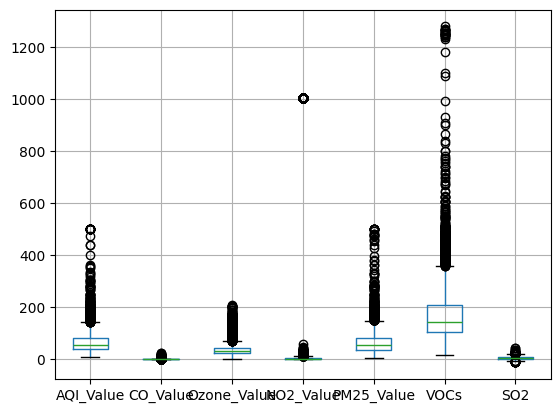

In [16]:
print_numerical_info(num_train_data)

#### Atribute corellation


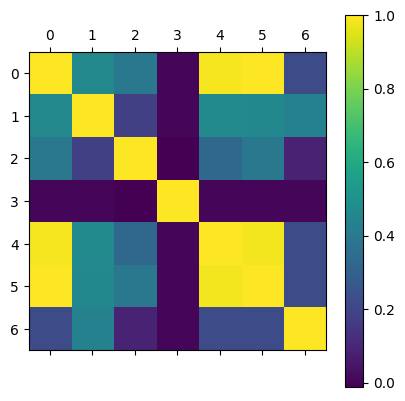

In [17]:
correlation = num_train_data.corr()
plt.matshow(correlation)
plt.colorbar()
plt.show()

Chi2 test for Country and Country:
  statistic: 678405.0
  p-value: 0.0

Chi2 test for Country and City:
  statistic: 678258.0
  p-value: 0.4495532124080549

Chi2 test for Country and CO_Category:
  statistic: 0.0
  p-value: 1.0

Chi2 test for Country and Ozone_Category:
  statistic: 1820.1211447312326
  p-value: 5.8229909502570764e-126

Chi2 test for Country and NO2_Category:
  statistic: 64.94264350733792
  p-value: 0.9999999995488775

Chi2 test for Country and PM25_Category:
  statistic: 3617.990368089555
  p-value: 0.0

Chi2 test for Country and Emissions:
  statistic: 3617.990368089555
  p-value: 0.0

Chi2 test for City and Country:
  statistic: 678258.0000000001
  p-value: 0.4495532124080153

Chi2 test for City and City:
  statistic: 22010171.999999203
  p-value: 0.23973444887666215

Chi2 test for City and CO_Category:
  statistic: 0.0
  p-value: 1.0

Chi2 test for City and Ozone_Category:
  statistic: 18768.0
  p-value: 0.4903911868634493

Chi2 test for City and NO2_Category:
  

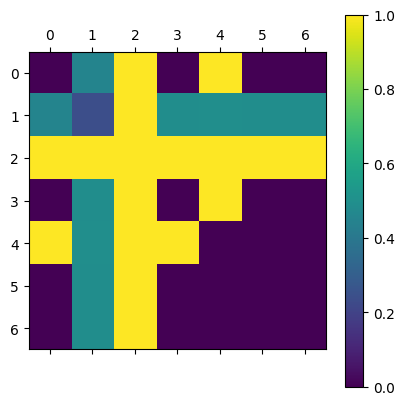

                                                Country          City  \
0                                                Brazil         Borba   
1                                                Mexico     Xoxocotla   
2     United Kingdom of Great Britain and Northern I...        Bootle   
3                                          South Africa   Piet Retief   
4                                               Germany    Schwaigern   
...                                                 ...           ...   
4688                 Venezuela (Bolivarian Republic of)   San Joaquin   
4689                                            Germany  Grevenbroich   
4690                                           Slovakia        Presov   
4691                                              Japan         Ogawa   
4692                           United States of America       Fremont   

     CO_Category Ozone_Category NO2_Category PM25_Category Emissions  
0           Good           Good         Good        

In [18]:
pvalues = np.zeros((len(cat_train_data.columns), len(cat_train_data.columns)))

for i, row in enumerate(cat_train_data.columns):
    for j, col in enumerate(cat_train_data.columns):
        observed = pd.crosstab(cat_train_data[row], cat_train_data[col])
        statistic = sp.stats.chi2_contingency(observed)
        pvalues[i, j] = statistic.pvalue
        print(f"Chi2 test for {row} and {col}:")
        print(f"  statistic: {statistic[0]}")
        print(f"  p-value: {statistic[1]}")
        print()

plt.matshow(pvalues)
plt.colorbar()
plt.show()
print(cat_train_data)

### Preprocessing


#### Imputing missing data


In [19]:
def impute_missing_numerical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer()
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)

In [20]:
def impute_missing_categorical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer(strategy="most_frequent")
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)

In [21]:
num_train_data = impute_missing_numerical_data(num_train_data)
cat_train_data = impute_missing_categorical_data(cat_train_data)

#### Extreme values


In [22]:
def remove_extreme_values(data: pd.DataFrame):
    for col in data.columns:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        data[col].clip(lower_bound, upper_bound, inplace=True)
    return data

In [23]:
remove_extreme_values(num_train_data)

/tmp/ipykernel_44417/3383979482.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].clip(lower_bound, upper_bound, inplace=True)
/tmp/ipykernel_44417/3383979482.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

,AQI_Value,CO_Value,Ozone_Value,NO2_Value,PM25_Value,VOCs,SO2
0,40.0,1.0,2.000000,0.0,40.0,101.096055,0.056836
1,72.0,1.0,8.000000,9.0,72.0,197.005317,7.367540
2,65.0,1.0,34.706189,0.0,65.0,169.885661,-2.136784
3,141.5,1.0,20.000000,7.0,147.5,358.390155,13.901147
4,66.0,1.0,37.000000,2.0,66.0,173.630043,-3.814499
...,...,...,...,...,...,...,...
4688,63.0,1.0,14.000000,8.0,63.0,172.491496,3.057514
4689,43.0,1.0,26.000000,4.0,43.0,118.645472,7.383370
4690,76.0,1.0,35.000000,2.0,76.0,188.995530,3.172634
4691,82.0,1.0,11.000000,10.0,82.0,209.344709,7.537093


#### Redundant attributes


We can see from the correlation matrix that columns _0_, _4_ and _5_ are very
strongly correlated (correlation index is **$\approx$ 1**), so, we can remove,
for example, columns _4_ and _5_.


In [ ]:
# TODO
def remove_redundant_attributes(data: pd.DataFrame):
    del data["PM25_Value"]
    del data["VOCs"]


remove_redundant_attributes(num_train_data)

#### Domain standardization


In [25]:
def scale_data(data: pd.DataFrame) -> pd.DataFrame:
    scaler = sk.preprocessing.StandardScaler()
    scaler.fit(data)

    scaled_data = scaler.transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)

In [26]:
num_train_data = scale_data(num_train_data)

#### Categorical attributes encoding


In [27]:
def encode_categorical_attributes(data: pd.DataFrame):
    encoder = sk.preprocessing.LabelEncoder()

    for col in data.columns:
        encoder.fit(data[col])
        data.loc[:, col] = encoder.transform(data[col])

In [28]:
def encode_labels(data: pd.Series) -> pd.Series:
    encoder = sk.preprocessing.LabelEncoder()
    encoder.fit(data)

    return encoder.transform(data)

In [29]:
encode_categorical_attributes(cat_train_data)
train_labels = encode_labels(train_labels)

### Prediction


#### Train data

In [30]:
train_data = pd.concat([num_train_data, cat_train_data], axis=1)
print(train_data)

      AQI_Value  CO_Value  Ozone_Value  NO2_Value       SO2 Country  City  \
0     -0.719858       0.0    -2.069987  -0.821913 -0.819557      18   563   
1      0.158401       0.0    -1.650348   1.842539  0.575540      86  4597   
2     -0.033718       0.0     0.217480  -0.821913 -1.238165     139   560   
3      2.065871       0.0    -0.811069   1.250439  1.822344     121  3188   
4     -0.006272       0.0     0.377909  -0.229813 -1.558322      53  3697   
...         ...       ...          ...        ...       ...     ...   ...   
4688  -0.088609       0.0    -1.230709   1.546489 -0.246940     144  3592   
4689  -0.637521       0.0    -0.391430   0.362288  0.578561      53  1469   
4690   0.268184       0.0     0.238029  -0.229813 -0.224972     118  3289   
4691   0.432858       0.0    -1.440528   2.138590  0.607896      70  2953   
4692  -0.390511       0.0     0.447848  -0.229813  0.616456     141  1318   

     CO_Category Ozone_Category NO2_Category PM25_Category Emissions  
0   

#### Test data


In [31]:
raw_test_data = pd.read_csv("datasets/air_pollution_test.csv")
print(raw_test_data)

                                                Country          City  \
0                                                Brazil         Borba   
1                                                Mexico     Xoxocotla   
2     United Kingdom of Great Britain and Northern I...        Bootle   
3                                          South Africa   Piet Retief   
4                                               Germany    Schwaigern   
...                                                 ...           ...   
4688                 Venezuela (Bolivarian Republic of)   San Joaquin   
4689                                            Germany  Grevenbroich   
4690                                           Slovakia        Presov   
4691                                              Japan         Ogawa   
4692                           United States of America       Fremont   

      AQI_Value  CO_Value CO_Category  Ozone_Value Ozone_Category  NO2_Value  \
0            40         1        Good      

In [32]:
num_test_data, cat_test_data, test_labels = split_data(
    raw_test_data, numeric_columns, categorical_columns, label_columns
)

In [33]:
num_test_data = impute_missing_numerical_data(num_test_data)
cat_test_data = impute_missing_categorical_data(cat_test_data)
num_test_data = scale_data(num_test_data)
remove_redundant_attributes(num_test_data)
encode_categorical_attributes(cat_test_data)

In [34]:
test_labels = encode_labels(test_labels)
test_data = pd.concat([num_test_data, cat_test_data], axis=1)
print(test_data)

      AQI_Value  CO_Value   Ozone_Value  NO2_Value       SO2 Country  City  \
0     -0.575425 -0.241824 -1.276908e+00  -0.219185 -0.798404      18   563   
1     -0.002282  0.495591 -1.042657e+00  -0.173188  0.547675      86  4597   
2     -0.127657 -0.979240 -2.774085e-16  -0.219185 -1.202303     139   560   
3      1.645502  1.970421 -5.741557e-01  -0.183410  1.750672     121  3188   
4     -0.109746 -0.241824  8.955444e-02  -0.208963 -1.511211      53  3697   
...         ...       ...           ...        ...       ...     ...   ...   
4688  -0.163479 -0.241824 -8.084063e-01  -0.178299 -0.245906     144  3592   
4689  -0.521693 -0.241824 -3.399051e-01  -0.198742  0.550590      53  1469   
4690   0.069361 -0.241824  1.147089e-02  -0.208963 -0.224710     118  3289   
4691   0.176825  0.495591 -9.255317e-01  -0.127191  0.578894      70  2953   
4692  -0.360496 -0.241824  1.285962e-01  -0.208963  0.587153     141  1318   

     CO_Category Ozone_Category NO2_Category PM25_Category Emis

#### Classifiers

In [43]:
classifiers = [
    "Decision Tree",
    "Random Forest",
    "Logistic Regression",
    "Multi-Layer Perceptron",
]
scores = []

##### Decision Tree


In [44]:
def run_classifier(classifier, test_data: pd.DataFrame, test_labels: pd.Series) -> float:
    sk.metrics.ConfusionMatrixDisplay.from_estimator(
        classifier,
        test_data,
        test_labels,
    )
    plt.show()
    return classifier.score(test_data, test_labels)

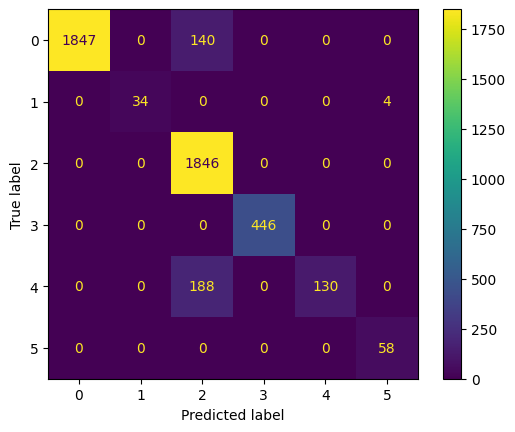

In [45]:
classifier = sk.tree.DecisionTreeClassifier()
classifier.fit(train_data, train_labels)

score = run_classifier(
    classifier,
    test_data,
    test_labels,
)
scores.append(score)

##### Random forest


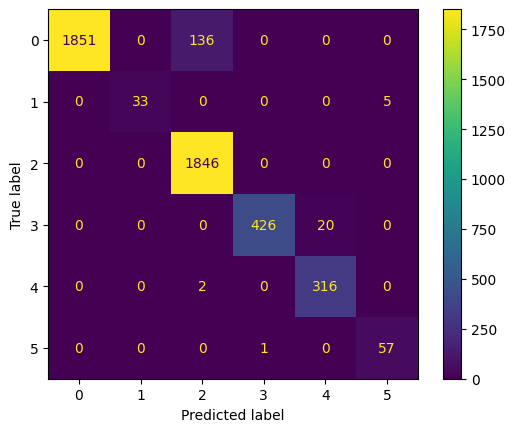

In [46]:
classifier = sk.ensemble.RandomForestClassifier()
classifier.fit(train_data, train_labels)

score = run_classifier(
    classifier,
    test_data,
    test_labels,
)
scores.append(score)

##### Logistic regression


In [ ]:
# class LogisticRegression:
#     TODO

In [47]:
score = 0
scores.append(score)

##### Multi-layered perceptron


Iteration 1, loss = 4.79442404
Iteration 2, loss = 1.68999119
Iteration 3, loss = 1.74658604
Iteration 4, loss = 1.62562504
Iteration 5, loss = 1.59575045
Iteration 6, loss = 1.56873266
Iteration 7, loss = 1.54371985
Iteration 8, loss = 1.52092312
Iteration 9, loss = 1.49881669
Iteration 10, loss = 1.53791330
Iteration 11, loss = 1.47740776
Iteration 12, loss = 1.45664521
Iteration 13, loss = 1.44158322
Iteration 14, loss = 1.42800970
Iteration 15, loss = 1.41604454
Iteration 16, loss = 1.40507662
Iteration 17, loss = 1.39430559
Iteration 18, loss = 1.38539217
Iteration 19, loss = 1.37675308
Iteration 20, loss = 1.36910007
Iteration 21, loss = 1.36154137
Iteration 22, loss = 1.35454199
Iteration 23, loss = 1.34798892
Iteration 24, loss = 1.34207169
Iteration 25, loss = 1.33647148
Iteration 26, loss = 1.33076450
Iteration 27, loss = 1.32583894
Iteration 28, loss = 1.35659677
Iteration 29, loss = 1.31965464
Iteration 30, loss = 1.31525703
Iteration 31, loss = 1.31161896
Iteration 32, los

/home/alex/Documents/facultate/teme/ia/ml/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


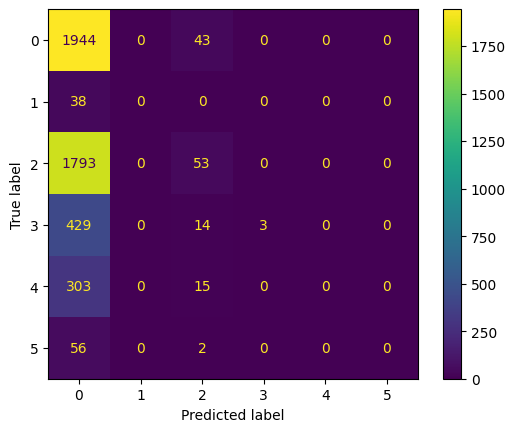

In [48]:
classifier = sk.neural_network.MLPClassifier(
    verbose=True, learning_rate="adaptive", solver="sgd"
)
classifier.fit(train_data, train_labels)

score = run_classifier(
    classifier,
    test_data,
    test_labels,
)
scores.append(score)

#### Classifier comparison

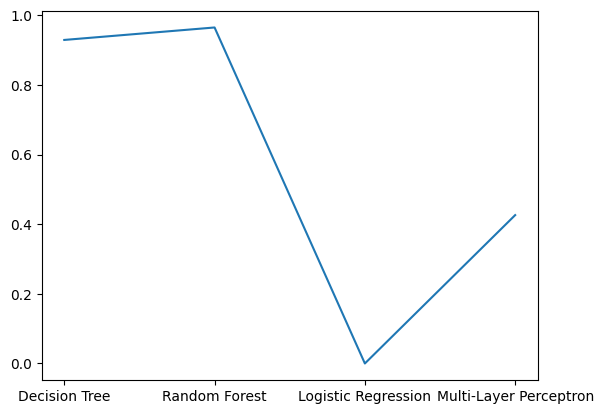

In [49]:
plt.plot(classifiers, scores)

## News popularity


In [ ]:
raw_train_data = pd.read_csv("datasets/news_popularity_train.csv")
print(raw_train_data)

In [ ]:
numeric_columns = [
    " days_since_published",
    " title_word_count",
    " content_word_count",
    " unique_word_ratio",
    " non_stop_word_ratio",
    " unique_non_stop_ratio",
    " external_links",
    " internal_links",
    " image_count",
    " video_count",
    " avg_word_length",
    " keyword_count",
    " keyword_worst_min_shares",
    " keywords_worst_max_shares",
    " keyword_worst_avg_shares",
    " keyword_best_min_shares",
    " keyword_best_max_shares",
    " keyword_best_avg_shares",
    " keyword_avg_min_shares",
    " keyword_avg_max_shares",
    " keyword_avg_avg_shares",
    " ref_min_shares",
    " ref_max_shares",
    " ref_avg_shares",
    " topic_0_relevance",
    " topic_1_relevance",
    " topic_2_relevance",
    " topic_3_relevance",
    " topic_4_relevance",
    " content_subjectivity",
    " content_sentiment",
    " positive_word_rate",
    " negative_word_rate",
    " non_neutral_positive_rate",
    " non_neutral_negative_rate",
    " avg_positive_sentiment",
    " min_positive_sentiment",
    " max_positive_sentiment",
    " avg_negative_sentiment",
    " min_negative_sentiment",
    " max_negative_sentiment",
    " title_subjectivity",
    " title_sentiment",
    " title_subjectivity_magnitude",
    " title_sentiment_magnitude",
    " engagement_ratio",
    " content_density",
]
categorical_columns = [
    "url",
    " channel_lifestyle",
    " channel_entertainment",
    " channel_business",
    " channel_social_media",
    " channel_tech",
    " channel_world",
    " day_monday",
    " day_tuesday",
    " day_wednesday",
    " day_thursday",
    " day_friday",
    " day_saturday",
    " day_sunday",
    " is_weekend",
    " publication_period",
]
label_columns = "popularity_category"

In [ ]:
def split_news_data(
    data: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    numeric_attrs = [attr for attr in numeric_columns if attr in data.columns]
    categorical_attrs = [attr for attr in categorical_columns if attr in data.columns]

    numeric_attrs = data[numeric_attrs]
    categorical_attrs = data[categorical_attrs]
    labels = data[label_columns]

    return numeric_attrs, categorical_attrs, labels


num_train_data, cat_train_data, train_labels = split_news_data(raw_train_data)
print(num_train_data)
print(cat_train_data)
print(train_labels)

### Exploratory data analysis


In [ ]:
print(num_train_data.describe())
num_train_data.boxplot()
plt.show()

#### Atribute corellation


In [ ]:
correlation = num_train_data.corr()
plt.matshow(correlation)
plt.colorbar()
plt.show()

### Preprocessing


#### Imputing missing data


In [ ]:
def impute_missing_numerical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer()
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)


num_train_data = impute_missing_numerical_data(num_train_data)

In [ ]:
def impute_missing_categorical_data(data: pd.DataFrame) -> pd.DataFrame:
    imputer = sk.impute.SimpleImputer(strategy="most_frequent")
    imputer.fit(data)

    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)


cat_train_data = impute_missing_categorical_data(cat_train_data)

#### Extreme values


#### Redundant attributes


We can see from the correlation matrix that columns _0_, _4_ and _5_ are very
strongly correlated (correlation index is **$\approx$ 1**), so, we can remove,
for example, columns _4_ and _5_.


In [ ]:
def remove_redundant_attributes(data: pd.DataFrame):
    del data["PM25_Value"]
    del data["VOCs"]


remove_redundant_attributes(num_train_data)

#### Domain standardization


In [ ]:
def scale_data(data: pd.DataFrame) -> pd.DataFrame:
    scaler = sk.preprocessing.StandardScaler()
    scaler.fit(data)

    scaled_data = scaler.transform(data)
    return pd.DataFrame(scaled_data, columns=data.columns)


num_train_data = scale_data(num_train_data)

#### Categorical attributes encoding


In [ ]:
def encode_categorical_attributes(data: pd.DataFrame):
    encoder = sk.preprocessing.LabelEncoder()

    for col in data.columns:
        encoder.fit(data[col])
        data.loc[:, col] = encoder.transform(data[col])


encode_categorical_attributes(cat_train_data)

In [ ]:
def encode_labels(data: pd.Series) -> pd.Series:
    encoder = sk.preprocessing.LabelEncoder()
    encoder.fit(data)

    return encoder.transform(data)


train_labels = encode_labels(train_labels)

### Prediction


In [ ]:
train_data = pd.concat([num_train_data, cat_train_data], axis=1)
print(train_data)

#### Test data


In [ ]:
raw_test_data = pd.read_csv("datasets/news_popularity_test.csv")
print(raw_test_data)

In [ ]:
num_test_data, cat_test_data, test_labels = split_data(raw_test_data)

In [ ]:
num_test_data = impute_missing_numerical_data(num_test_data)
cat_test_data = impute_missing_categorical_data(cat_test_data)
num_test_data = scale_data(num_test_data)
# remove_redundant_attributes(num_test_data)
encode_categorical_attributes(cat_test_data)

In [ ]:
test_labels = encode_labels(test_labels)
test_data = pd.concat([num_test_data, cat_test_data], axis=1)
print(test_data)

#### Decision Tree


In [ ]:
def run_classifier(classifier, test_data: pd.DataFrame, test_labels: pd.Series):
    sk.metrics.ConfusionMatrixDisplay.from_estimator(
        classifier,
        test_data,
        test_labels,
    )
    plt.show()

    predictions = classifier.predict(test_data)
    print("predicted values:", predictions)
    print("actual values:", test_labels)


classifier = sk.tree.DecisionTreeClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

#### Random forest


In [ ]:
classifier = sk.ensemble.RandomForestClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

#### Logistic regression


In [ ]:
classifier = sk.linear_model.LogisticRegression(max_iter=10000)
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)

#### Multi-layered perceptron


In [ ]:
classifier = sk.neural_network.MLPClassifier()
classifier.fit(train_data, train_labels)
run_classifier(
    classifier,
    test_data,
    test_labels,
)